# Model 4: LSTM Neural Network using a data set of Closing Stock Prices only

For Google Colab, install Yahoo Finance 

Yahoo_fin is a Python library that provides a simple and convenient interface for retrieving financial data from Yahoo Finance, and acts as a bridge between your Python code and the Yahoo Finance API. 

In [1]:
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=06f3c23944c048f93a4b6b6b0dd8b6fd6757cca44f4d210f3e5a5ea29b68908e
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24570 sha256=1398f66a858c48a0a6d530c671fa4e154ae97c7e7698a0339f832eafb8cb4c88
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

Import the libraries and variables to be used in the code

In [2]:
# Import libraries 
import numpy as np
import pandas as pd
import time as tm
import datetime as dt
import tensorflow as tf

from yahoo_fin import stock_info as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Activation
from keras.layers import Bidirectional

# Graphics library
import matplotlib.pyplot as plt

Set-up the variables

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GS for Goldman Sachs
STOCK = 'GS'

# Current date
date_now = tm.strftime('2023-06-01')
date_4_years_back = tm.strftime('2019-01-01')

##Load the data and create a DataFrame

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_4_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
# Display data loaded in the DataFrame
init_df

,open,high,low,close,adjclose,volume,ticker
2019-01-02,164.330002,172.250000,163.350006,172.029999,155.290848,3999400,GS
2019-01-03,170.660004,171.770004,168.289993,169.509995,153.016052,4060200,GS
2019-01-04,172.990005,176.000000,171.100006,175.050003,158.017029,3788300,GS
2019-01-07,175.229996,177.830002,172.270004,176.020004,158.892639,3152100,GS
2019-01-08,177.779999,178.100006,172.899994,175.369995,158.305847,2692700,GS
...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
# check the updated data frame
init_df

# save a copy of the original close prices to be used later
saved_df = init_df.copy()

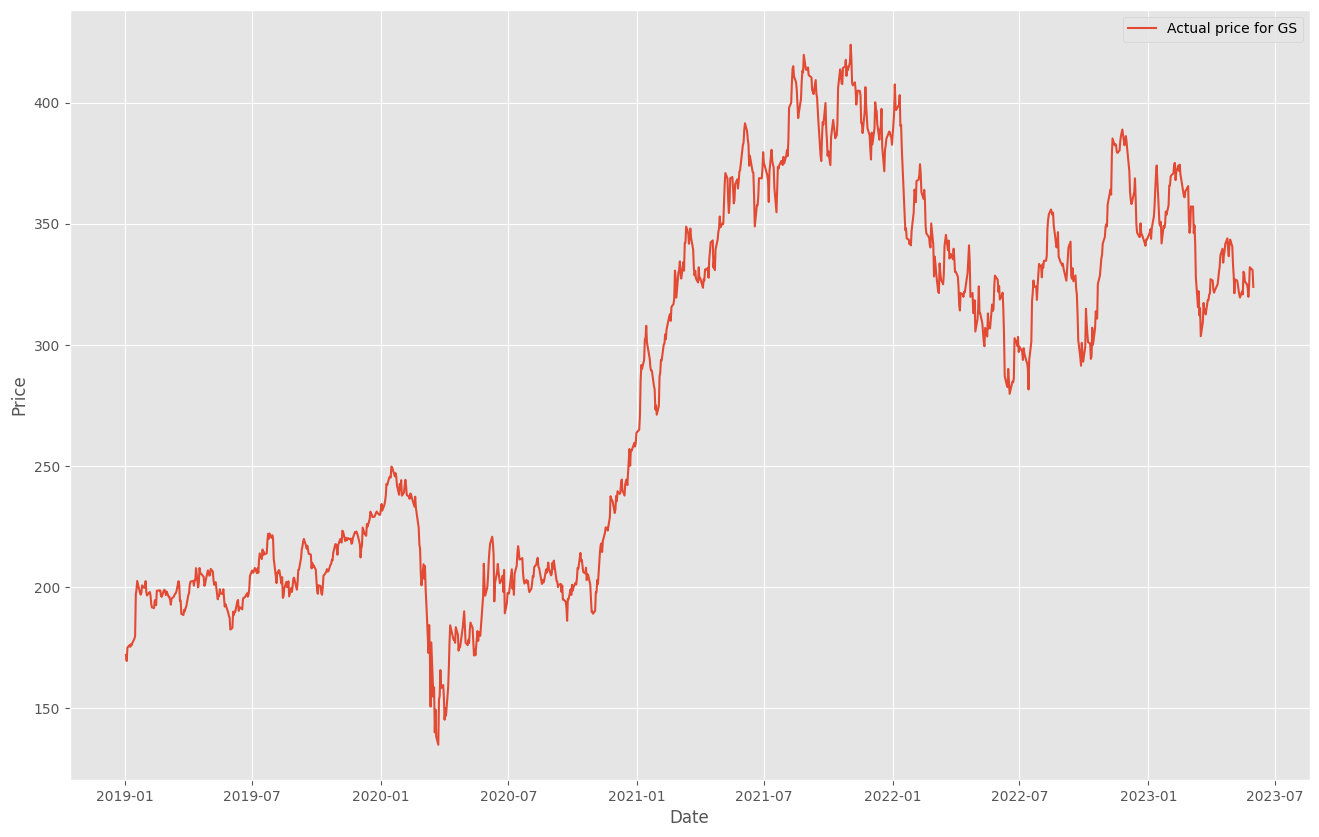

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'], label='Closing Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()



##Check for outliers to confirm which scaler to use

In [9]:
# Assuming you have the Goldman Sachs closing prices stored in a DataFrame called 'data'
# with a column named 'Closing_Price'

# Calculate the quartiles and interquartile range (IQR)
Q1 = init_df['close'].quantile(0.25)
Q3 = init_df['close'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify outliers
outliers = init_df[(init_df['close'] < lower_fence) | (init_df['close'] > upper_fence)]

# Print the outliers
print("Outliers:")
print(outliers)



Outliers:
Empty DataFrame
Columns: [close, date]
Index: []


## Scale the data

* MinMaxScaler: This scaler is commonly used for scaling stock prices because it preserves the relative relationships between the data points and maps the data to a specific range (e.g., [0, 1]). It can be suitable when you want to retain the original distribution and range of the data.

OR

* RobustScaler: When dealing with stock prices that may have outliers or heavy-tailed distributions, RobustScaler can be more appropriate. It scales the data using robust statistics like the median and interquartile range, making it more robust to outliers.


Since there are no outliers in the GS closing prices, we will use MinMaxScaler

In [10]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [11]:
# check the scaled data
init_df

,close,date
2019-01-02,0.128289,2019-01-02
2019-01-03,0.119565,2019-01-03
2019-01-04,0.138743,2019-01-04
2019-01-07,0.142101,2019-01-07
2019-01-08,0.139850,2019-01-08
...,...,...
2023-05-24,0.639850,2023-05-24
2023-05-25,0.653939,2023-05-25
2023-05-26,0.682083,2023-05-26
2023-05-30,0.677998,2023-05-30


## Create the Data Preparation function

In [12]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

## Create the Training Model function

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(Bidirectional(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))) # First layer using Bidirectional LSTM with 60 memory cells
  model.add(Dropout(0.3)) # Add a dropout layer of rate=0.3
  model.add(LSTM(120, return_sequences=False)) # Add another LSTM layer with 120 memory cells
  model.add(Dropout(0.3)) # Add a dropout layer of rate=0.3
  model.add(Dense(20)) # Add a dense fully connected layer with 20 units
  model.add(Activation('relu')) # Add activation layer using relu
  model.add(Dense(1)) # Add the final Dense layer with one unit, and is the layer that will produce a single prediction value
  model.add(Activation('relu')) # Add another activation layer as last layer

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
PrepareData(3) # 3 days

(               close       date    future
 2019-01-02  0.128289 2019-01-02  0.142101
 2019-01-03  0.119565 2019-01-03  0.139850
 2019-01-04  0.138743 2019-01-04  0.143658
 2019-01-07  0.142101 2019-01-07  0.142031
 2019-01-08  0.139850 2019-01-08  0.145251
 ...              ...        ...       ...
 2023-05-19  0.661797 2023-05-19  0.639850
 2023-05-22  0.657539 2023-05-22  0.653939
 2023-05-23  0.652866 2023-05-23  0.682083
 2023-05-24  0.639850 2023-05-24  0.677998
 2023-05-25  0.653939 2023-05-25  0.654009
 
 [1108 rows x 3 columns],
 array([[0.6757477 ],
        [0.67367065],
        [0.6617972 ],
        [0.6575395 ],
        [0.65286624],
        [0.63985044],
        [0.65393937],
        [0.68208253],
        [0.6779977 ],
        [0.65400857]], dtype=float32),
 array([[[0.1282885521053198, Timestamp('2019-01-02 00:00:00')],
         [0.11956519212932154, Timestamp('2019-01-03 00:00:00')],
         [0.13874273453890867, Timestamp('2019-01-04 00:00:00')],
         ...,
        

## Train the Model

In [15]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
138/138 [==============================] - 9s 15ms/step - loss: 0.0138
Epoch 2/80
138/138 [==============================] - 2s 16ms/step - loss: 0.0036
Epoch 3/80
138/138 [==============================] - 2s 15ms/step - loss: 0.0028
Epoch 4/80
138/138 [==============================] - 2s 15ms/step - loss: 0.0027
Epoch 5/80
138/138 [==============================] - 2s 15ms/step - loss: 0.0021
Epoch 6/80
138/138 [==============================] - 2s 15ms/step - loss: 0.0024
Epoch 7/80
138/138 [==============================] - 3s 21ms/step - loss: 0.0018
Epoch 8/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 9/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 10/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 11/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 12/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 13/80
138/13

In [16]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GS prediction for upcoming 3 days (329.53$, 327.81$, 329.06$)


## Test the trained model, apply to the same DataFrame used for training

* Test data needs to the same sequence as the training data because this is a time series
* Test data needs to be the same shape and same sequence length
* Therefore, we are using the same DataFrame to test

In [17]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed


# Transform back the closing prices to its original form 
original_close = scaler.inverse_transform(copy_df[['close']])
copy_df['original_close'] = original_close

# Display the new DataFrame
print(copy_df)



35/35 [==============================] - 0s 4ms/step
               close       date  predicted_close  original_close
2019-01-02  0.128289 2019-01-02       179.910004      172.029999
2019-01-03  0.119565 2019-01-03       197.080002      169.509995
2019-01-04  0.138743 2019-01-04       199.089996      175.050003
2019-01-07  0.142101 2019-01-07       202.539993      176.020004
2019-01-08  0.139850 2019-01-08       197.679993      175.369995
...              ...        ...              ...             ...
2023-05-24  0.639850 2023-05-24       323.640503      319.809998
2023-05-25  0.653939 2023-05-25       325.835968      323.880005
2023-05-26  0.682083 2023-05-26       332.010010      332.010010
2023-05-30  0.677998 2023-05-30       330.829987      330.829987
2023-05-31  0.654009 2023-05-31       323.899994      323.899994

[1111 rows x 4 columns]


In [18]:
# Add the predictions for 6/1, 6/2, and 6/3 to the DataFrame
import datetime as dt
date_now = dt.date(2023, 6, 1)
date_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=1)
date_after_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=2)
# Adds a new row to the DataFrame for date_now containing the predicted price
copy_df.loc[date_now] = [0, f'{date_now}', predictions[0], 0]
# Adds a new row to the DataFrame for date_tomorrow containing the predicted price
copy_df.loc[date_tomorrow] = [0, f'{date_tomorrow}', predictions[1], 0]
# Adds a new row to the DataFrame for date_after_tomorrow containing the predicted price
copy_df.loc[date_after_tomorrow] = [0, f'{date_after_tomorrow}', predictions[2], 0]

copy_df.tail(10)

<ipython-input-18-b7685a4489fd>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [0, f'{date_tomorrow}', predictions[1], 0]
<ipython-input-18-b7685a4489fd>:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [0, f'{date_after_tomorrow}', predictions[2], 0]


,close,date,predicted_close,original_close
2023-05-22 00:00:00,0.657539,2023-05-22 00:00:00,328.291077,324.920013
2023-05-23 00:00:00,0.652866,2023-05-23 00:00:00,326.743439,323.570007
2023-05-24 00:00:00,0.639850,2023-05-24 00:00:00,323.640503,319.809998
2023-05-25 00:00:00,0.653939,2023-05-25 00:00:00,325.835968,323.880005
2023-05-26 00:00:00,0.682083,2023-05-26 00:00:00,332.010010,332.010010
2023-05-30 00:00:00,0.677998,2023-05-30 00:00:00,330.829987,330.829987
2023-05-31 00:00:00,0.654009,2023-05-31 00:00:00,323.899994,323.899994
2023-06-01,0.000000,2023-06-01,329.530000,0.000000
2023-06-02,0.000000,2023-06-02,327.810000,0.000000
2023-06-03,0.000000,2023-06-03,329.060000,0.000000


In [19]:
copy_df.dtypes

close              float64
date                object
predicted_close    float64
original_close     float64
dtype: object

## Add back the original closing prices from the saved DataFrame

In [20]:
# To add back the original close price to the DataFrame

# Make a copy of the initial DataFrame
for_merge = saved_df.copy()

# Create the column 'date' based on the index column
for_merge['date'] = for_merge.index
for_merge['date'] = pd.to_datetime(for_merge['date'])

# Display
for_merge

,close,date
2019-01-02,172.029999,2019-01-02
2019-01-03,169.509995,2019-01-03
2019-01-04,175.050003,2019-01-04
2019-01-07,176.020004,2019-01-07
2019-01-08,175.369995,2019-01-08
...,...,...
2023-05-24,319.809998,2023-05-24
2023-05-25,323.880005,2023-05-25
2023-05-26,332.010010,2023-05-26
2023-05-30,330.829987,2023-05-30


In [21]:
for_merge.dtypes

close           float64
date     datetime64[ns]
dtype: object

In [22]:
# Convert the date column to datetime format in dataframes
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Merge the two dataframes based on the date column
merged_df = pd.merge(copy_df, for_merge[['date', 'close']], on='date', how='left')


# Print the merged dataframe
merged_df.dtypes

close_x                   float64
date               datetime64[ns]
predicted_close           float64
original_close            float64
close_y                   float64
dtype: object

In [23]:
# Convert null values to a specific value
merged_df = merged_df.fillna(0)

In [24]:
merged_df

,close_x,date,predicted_close,original_close,close_y
0,0.128289,2019-01-02,179.910004,172.029999,172.029999
1,0.119565,2019-01-03,197.080002,169.509995,169.509995
2,0.138743,2019-01-04,199.089996,175.050003,175.050003
3,0.142101,2019-01-07,202.539993,176.020004,176.020004
4,0.139850,2019-01-08,197.679993,175.369995,175.369995
...,...,...,...,...,...
1109,0.677998,2023-05-30,330.829987,330.829987,330.829987
1110,0.654009,2023-05-31,323.899994,323.899994,323.899994
1111,0.000000,2023-06-01,329.530000,0.000000,0.000000
1112,0.000000,2023-06-02,327.810000,0.000000,0.000000


## Calculating Accuracy using MAE, RMSE and MAPE

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use the actual prices in a list or array
# [:-3] to not include the last three rows as they will skew the calculation since it does not have the actual close price
actual_prices = merged_df['close_y'][:-3]

# Use the predicted prices 
# [:-3] to not include the last three rows as they will skew the calculation since it does not have the actual close price
predicted_prices = merged_df['predicted_close'][:-3]

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Print the calculated metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 4.305191534473272
Root Mean Squared Error (RMSE): 5.368725865860256


In [26]:
def calculate_mape(actual, predicted):
    # Ensure both actual and predicted arrays have the same shape
    actual = actual_prices
    predicted = predicted_prices

    # Calculate the percentage error for each data point
    # Multiplying the below by 100 already converts the number to %
    percentage_errors = np.abs((actual - predicted) / actual) * 100

    # Calculate the mean percentage error
    mape = np.mean(percentage_errors)

    return mape

# Assuming you have the actual prices in a list called actual_prices
# and the predicted prices in a list called predicted_prices
mape = calculate_mape(actual_prices, predicted_prices)

# Round the MAPE value to two decimal places
mape_rounded = round(mape, 2)

print(f"Mean Absolute Percentage Error (MAPE): {mape_rounded}%")

Mean Absolute Percentage Error (MAPE): 1.84%


##Create a chart of the Actual Closing Prices and Predicted Prices

In [27]:
# Set the 'date' column as the index
merged_df.set_index('date', inplace=True)

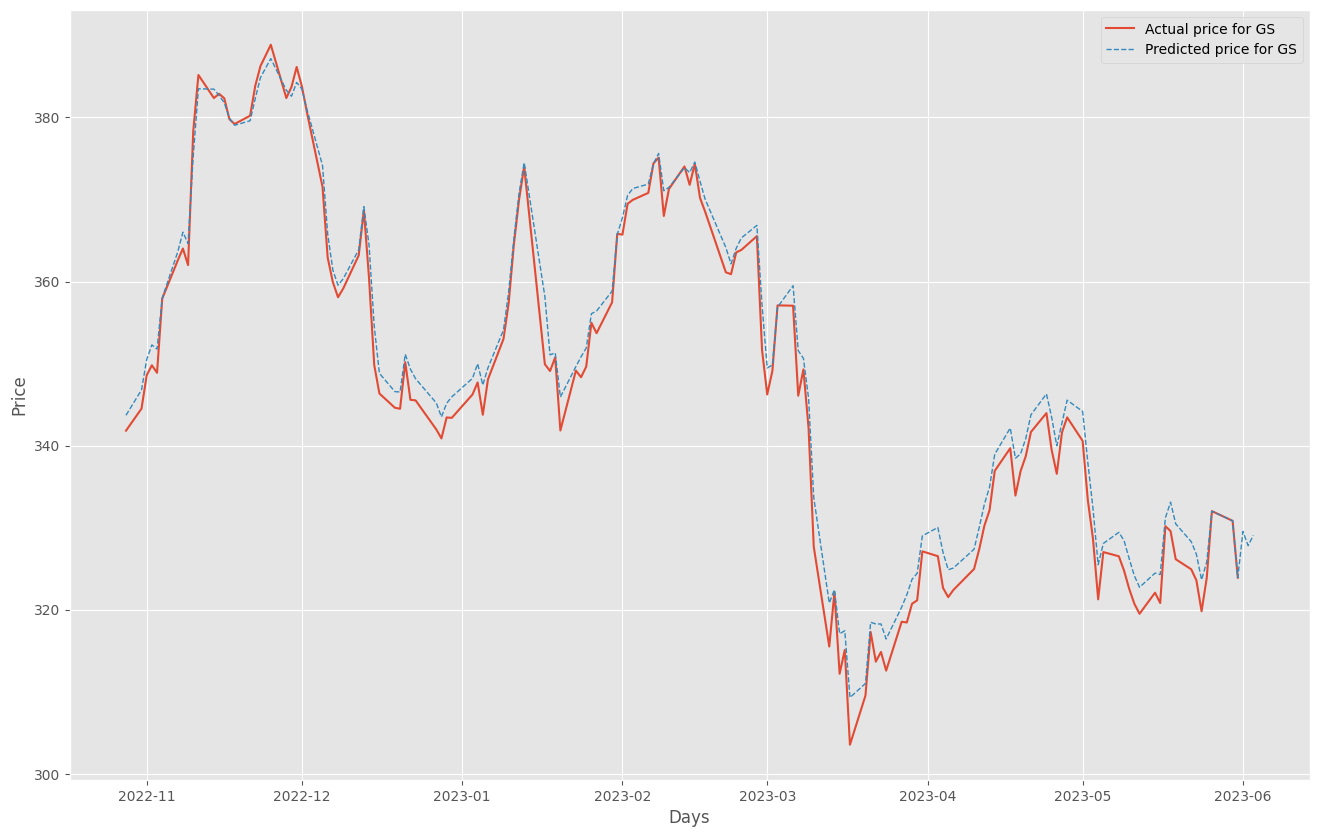

In [28]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(merged_df['close_y'][-150:].head(147))
plt.plot(merged_df['predicted_close'][-150:].head(150), linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()